In [89]:
import keras.optimizers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_lstm_dataset(data, dates, time_steps=1, forecast_days=60):
    X, y, date_list = [], [], []
    for i in range(len(data) - time_steps - forecast_days + 1):
        end_ix = i + time_steps
        seq_x, seq_y = data[i:end_ix, :], data[end_ix + forecast_days - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
        date_list.append(dates[end_ix + forecast_days - 1])  # Сохраняем соответствующую дату
    return np.array(X), np.array(y), date_list



# Define the function to create LSTM dataset and save it
def create_and_save_lstm_dataset(file_id, n_intervals,forecast_days, datasets_folder='../datasets', scalers_folder='../scalers'):
    file_path = '../data_updated/' + file_names[file_id]
    dataset = pd.read_csv(file_path).dropna()

    target_column = dataset.pop('Цена')
    dates = dataset.pop('Дата')
    dataset['Цена'] = target_column

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_dataset = scaler.fit_transform(dataset)


    X_ltsm, y_ltsm, date_list = create_lstm_dataset(normalized_dataset, dates,n_intervals, forecast_days=forecast_days)

    train_size = int(len(X_ltsm) * 0.8)
    X_train_ltsm, X_test_ltsm = X_ltsm[:train_size], X_ltsm[train_size:]
    y_train_ltsm, y_test_ltsm = y_ltsm[:train_size], y_ltsm[train_size:]

    scaler_filename = '../scalers/'+file_names[file_id]+'_scaler.pkl'
    with open(scaler_filename, 'wb') as scaler_file:
        joblib.dump(scaler, scaler_file)

    # Сохранение данных X_train и y_train_ltsm
    X_train_ltsm_file_path = os.path.join(datasets_folder, f'X_train_ltsm_{file_names[file_id]}')
    X_test_ltsm_file_path = os.path.join(datasets_folder, f'X_test_ltsm_{file_names[file_id]}')
    y_train_ltsm_file_path = os.path.join(datasets_folder, f'y_train_ltsm_{file_names[file_id]}')
    y_test_ltsm_file_path = os.path.join(datasets_folder, f'y_test_ltsm_{file_names[file_id]}')

    np.save(X_train_ltsm_file_path, X_train_ltsm)
    np.save(X_test_ltsm_file_path, X_test_ltsm)
    np.save(y_train_ltsm_file_path, y_train_ltsm)
    np.save(y_test_ltsm_file_path, y_test_ltsm)

    print(f'Data saved to {X_train_ltsm_file_path} and {X_test_ltsm_file_path}')
    print(f'Data saved to {y_train_ltsm_file_path} and {y_test_ltsm_file_path}')
    return date_list
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import sqrt
from keras.losses import mean_squared_error

from free_utils import *




In [538]:
# Загрузка данных
file_id =11  # Замените на нужный идентификатор файла
n_intervals = 7  # Замените на необходимое количество временных интервалов
n_features = 18  # Замените на количество признаков в данных (ваш случай)
forecast_days = 1
date_list=create_and_save_lstm_dataset(file_id, n_intervals,forecast_days=forecast_days)
keras.optimizers.Adadelta
data, scaler = load_data(file_id, n_intervals, n_features)
# Преобразование date_list в DataFrame
date_df = pd.DataFrame({'Date': date_list})
# Преобразование столбца 'Date' в формат datetime
date_df['Date'] = pd.to_datetime(date_df['Date'])
X_test_ltsm,X_train_ltsm, y_test_ltsm,y_train_ltsm  = data
len(X_train_ltsm)

Data saved to ../datasets\X_train_ltsm_Прошлые данные - GAZP (3).csv and ../datasets\X_test_ltsm_Прошлые данные - GAZP (3).csv
Data saved to ../datasets\y_train_ltsm_Прошлые данные - GAZP (3).csv and ../datasets\y_test_ltsm_Прошлые данные - GAZP (3).csv


2134

In [542]:
def create_model(X_train_ltsm,forecast_days):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_ltsm.shape[1], X_train_ltsm.shape[2])))
    model.add(Dropout(0.12))
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.22))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.22))

    model.add(Dense(units=forecast_days, activation='relu'))

    model.compile(optimizer='adam', loss='mse')
    return model



Model architecture: LSTM_128xTrue_LSTM_16xFalse_Dense32_Dense1
Epoch 1/30
67/67 [==============================] - 5s 24ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 2/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0064
Epoch 3/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 4/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 5/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 0.0077
Epoch 7/30
67/67 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 0.0114
Epoch 8/30
67/67 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0124
Epoch 9/30
67/67 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0086


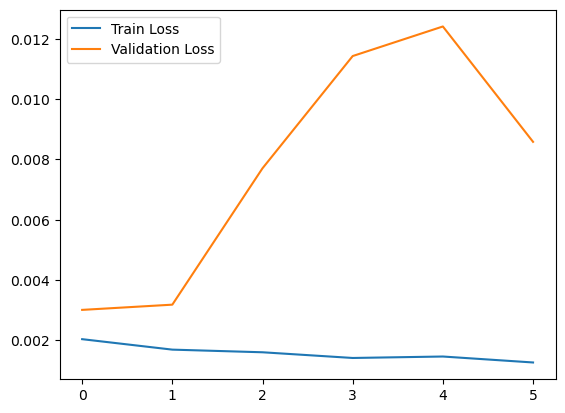

In [543]:

# Создание модели
model = create_model(X_train_ltsm,forecast_days=1)
# Формируем строку для описания архитектуры модели
def get_model_architecture(model):
    architecture = ""
    for layer in model.layers:
        if isinstance(layer, LSTM):
            architecture += f"LSTM_{layer.units}x{layer.return_sequences}_"
        elif isinstance(layer, Dense):
            architecture += f"Dense{layer.units}_"
    return architecture[:-1]  # Убираем последний символ "_"

model_architecture = get_model_architecture(model)
print("Model architecture:", model_architecture)
# Обучение модели
history = train_model(model, X_train_ltsm, y_train_ltsm, X_test_ltsm, y_test_ltsm, file_id)

# Визуализация истории обучения
plot_training_history(history)

In [544]:
results = model.evaluate(X_test_ltsm, y_test_ltsm, batch_size=32)

17/17 [==============================] - 0s 6ms/step - loss: 0.0030


In [545]:
yhat = model.predict(X_test_ltsm)
X_train_ltsm_res = X_train_ltsm.reshape((X_train_ltsm.shape[0], n_intervals*n_features))
X_test_ltsm_res = X_test_ltsm.reshape((X_test_ltsm.shape[0], n_intervals*n_features))

inv_y_train = invert_scaling_for_actual(y_train_ltsm, X_train_ltsm_res, n_features, scaler)
inv_yhat = invert_scaling_for_forecast(yhat, X_test_ltsm_res, n_features, scaler)
inv_y_test = invert_scaling_for_actual(y_test_ltsm, X_test_ltsm_res, n_features, scaler)

yhat_train = model.predict(X_train_ltsm)
inv_yhat_train = invert_scaling_for_forecast(yhat_train, X_train_ltsm_res, n_features, scaler)


67/67 [==============================] - 0s 4ms/step


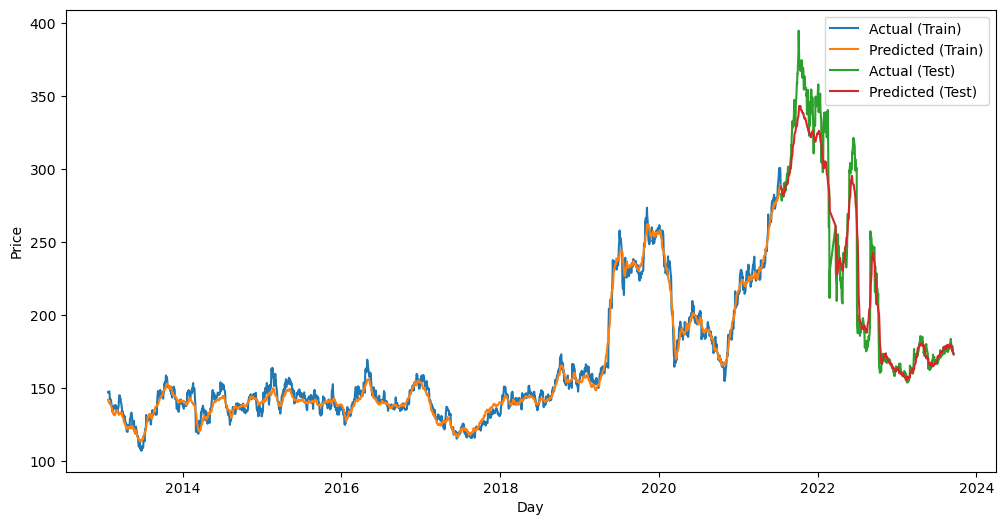

In [546]:
# Создаем датафреймы для каждого массива
df_yhat_train = pd.DataFrame({'yhat_train': inv_yhat_train})
df_yhat = pd.DataFrame({'yhat': inv_yhat})
df_y_test = pd.DataFrame({'y_test': inv_y_test})
df_y_train = pd.DataFrame({'y_train': inv_y_train})

# Объединяем их в один датафрейм
result_df_pred = pd.concat([df_yhat_train, df_yhat], axis=0)
result_df_true = pd.concat([df_y_train,df_y_test], axis=0)
result_df_true = result_df_true.reset_index()
result_df_pred = result_df_pred.reset_index()
result_df_true['Дата'] = date_df
results_all = pd.concat([result_df_true,result_df_pred], axis=1)
results_all=results_all.drop(columns='index')
plot_results(results_all['y_train'], results_all['y_test'], results_all['yhat'],results_all['yhat_train'],results_all['Дата'])


In [547]:
# Использование функции для расчета метрик
metrics = calculate_metrics( results_all['y_test'].dropna(), results_all['yhat'].dropna())

# Вывод результатов
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.3f}")    

RMSE: 15.781
MAE: 10.487
MAPE: 4.003
R-squared: 0.954


In [548]:
# Создайте новый столбец 'Shifted_y_test' в results_all

results_all['Shifted_y_test'] = results_all['y_test'].shift(-forecast_days)

# result_list = []
# next_day_prediction = inv_yhat
# 
# for i in range(0,len(inv_yhat)):
#     if i <= 29:
#         current_price = inv_y_train[-30+i]
#     else:
#         current_price = inv_y_test[i-30]
# 
#     # Добавьте значения в общий датафрейм (или список)
# result_list.append({"Current_Price": current_price})
# result_df = pd.DataFrame(result_list)
# result_df['Next_30_Day_Prediction']=inv_yhat
# result_df
# import matplotlib.pyplot as plt
# 
# # График для Current_Price
# plt.plot(results_all['Дата'], results_all['Shifted_y_test'], label='Цена на момент предсказания ')
# 
# # График для Next_30_Day_Prediction сдвинутый на 30 дней вперед
# plt.plot(results_all['Дата'] , results_all['yhat'], label=f'Next_{forecast_days}_Day_Prediction')
# 
# plt.xlabel('Дни')
# plt.ylabel('Цена')
# plt.legend()
# plt.show()
#     

In [552]:
zxc = len(results_all)-len(results_all['yhat'].dropna())
# Создаем случайные данные для примера
days = results_all['Дата']
current_prices = results_all['Shifted_y_test']
predictions =results_all['yhat']

# Инициализация переменных для стратегии
buy_points = []
sell_points = []

position = None
buy_price = None
sell_price = None
profit = 0

commission_rate = 0.04  # Комиссия в 4%
price_trashhold = 5
# Применение торговой стратегии
for i in range(0, len(current_prices)):
    current_price = current_prices.iloc[i]
    next_day_prediction = predictions.iloc[i]
    percentage_change = ((current_price - next_day_prediction) / next_day_prediction) * 100
    price_difference = abs(percentage_change)
    if price_difference>price_trashhold:
        if next_day_prediction > current_price:
            if position != "buy":
                position = "buy"
                buy_price = current_price * (1 + commission_rate)  # Учитываем комиссию при покупке
                profit-=buy_price
                buy_points.append(i)
                # print('BUY',i)
                # print(current_price)
                # print(next_day_prediction)
        else:
            if position == "buy":
                position = "sell"
                sell_price = current_price * (1 - commission_rate)  # Учитываем комиссию при продаже
                profit += sell_price
                sell_points.append(i)
                # print('SELL',i)
                # print(current_price)
                # print(next_day_prediction)

current_prices = results_all['Shifted_y_test']

for i in range(len(buy_points)-len(sell_points)):
    profit+=current_prices.dropna().iloc[-1] * (1 - commission_rate)
# График для Current_Price
buy_dates = days.iloc[buy_points]
sell_dates = days.iloc[sell_points]

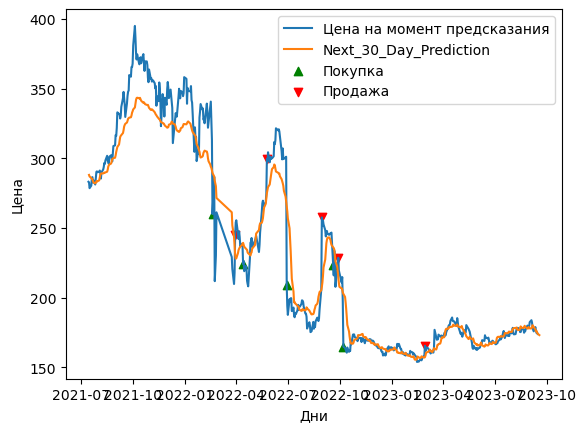

In [553]:
plt.plot(days, current_prices, label='Цена на момент предсказания')

# График для Next_30_Day_Prediction сдвинутый на 30 дней вперед
plt.plot(days , predictions, label='Next_30_Day_Prediction')

plt.scatter(buy_dates, current_prices.iloc[buy_points], c='g', marker='^', label='Покупка')
plt.scatter(sell_dates, current_prices.iloc[sell_points], c='r', marker='v', label='Продажа')

plt.xlabel('Дни')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [554]:
buy_and_hold_profit = -(current_prices.dropna().iloc[0] * (1 - commission_rate))
buy_and_hold_profit += (current_prices.dropna().iloc[-1] * (1 - commission_rate))
# Вывод результатов
print(f"Прибыль/Убыток стратегии 'buy and hold': {buy_and_hold_profit:.2f}")

print(f"Прибыль/Убыток вашей стратегии: {profit:.2f}")


Прибыль/Убыток стратегии 'buy and hold': -104.81
Прибыль/Убыток вашей стратегии: 23.75
